## Word2Vec

Набор данных содержит равное количество позитивных и негативных твитов, общее количество которых составляет ~200 000. Мы случайным образом отбираем позитивные и негативные твиты, чтобы разделить исходный набор данных на два набора для обучения и тестирования в соотношении 80/20. Затем обучаем модель Word2Vec на обучающем наборе данных.

Чтобы предотвратить утечку данных из тестового набора, мы не обучаем Word2Vec на тестовом наборе, пока наш классификатор не обучится на обучающем наборе. Чтобы создать входные данные для классификатора, используем усредненный вектор, полученный из всех векторов слов в твите. Для реализации машинного обучения будем использовать библиотеку scikit-learn.

Вначале импортируем данные и обучаем модель Word2Vec.

In [1]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.cross_validation import train_test_split
from gensim.models.word2vec import Word2Vec

with open('extra_data/prepared_tweets.txt', 'r') as infile:
    tweets = infile.readlines()
    
with open('extra_data/targets.txt', 'r') as infile:
    y = infile.readlines()

In [4]:
x_train, x_test, y_train, y_test = train_test_split(tweets, y, test_size=0.2)

In [5]:
print "x_train num:", len(x_train)
print "y_train num:", len(y_train)
print "x_test num:", len(x_test)
print "x_test num:", len(y_test)

x_train num: 181467
y_train num: 181467
x_test num: 45367
x_test num: 45367


In [6]:
def cleanText(corpus):
    corpus = [z.lower().replace('\n','').split() for z in corpus]
    return corpus

x_train = cleanText(x_train)
x_test = cleanText(x_test)

In [7]:
y_train = [int(y.strip()) for y in y_train]
y_test = [int(y.strip()) for y in y_test]

In [8]:
from gensim.models.word2vec import Word2Vec

# список параметров, которые можно менять по вашему желанию
num_features = 512  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 8     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

w2v = Word2Vec(workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

In [9]:
#build vocab
w2v.build_vocab(x_train)

In [10]:
#Train the model over train_reviews (this may take several minutes)
w2v.train(x_train)

7913787

In [23]:
#Build word vector for training set by using the average value of all word vectors in the tweet, then scale
def buildWordVector(text, size, w2v):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

Масштабирование – это часть процесса стандартизации, в рамках которого мы приводим наш набор данных к гауссовому распределению со средним значением, равным нулю.

Как следствие, значения, превышающие среднее, будут положительными, а те, что меньше него, – отрицательными. Для эффективной работы многих моделей машинного обучения требуются масштабированные наборы данных, особенно для моделей с большим количеством признаков, таких как текстовые классификаторы.

In [12]:
from sklearn.preprocessing import scale
train_vecs = np.concatenate([buildWordVector(z, num_features, w2v) for z in x_train])
train_vecs = scale(train_vecs)

#Train word2vec on test tweets
w2v.train(x_test)

1961369

Мы должны создать векторы тестового набора и масштабировать их для оценки.

In [13]:
#Build test tweet vectors then scale
test_vecs = np.concatenate([buildWordVector(z, num_features, w2v) for z in x_test])
test_vecs = scale(test_vecs)

Далее мы проверим наш классификатор, рассчитав точность прогнозирования на тестовых данных, а также проанализируем ROC-кривую. ROC-кривая характеризует соотношение истинноположительных и ложноположительных результатов классификации при варьировании параметра модели.

В нашем случае мы регулируем пороговую вероятность классификации твита, как позитивного или негативного. В общем случае, чем больше площадь под кривой (AUC), тем лучше наша модель максимизирует количество истинноположительных и минимизирует количество ложноположительных результатов. 

Для начала мы обучаем наш классификатор, используя в данном случае стохастический градиентный спуск (stochastic gradient descent) для логистической регрессии.

In [15]:
#Use classification algorithm (i.e. Stochastic Logistic Regression) on training set, then assess model performance on test set
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss='log', penalty='l1')
lr.fit(train_vecs, y_train)

print 'Test Accuracy: %.2f'%lr.score(test_vecs, y_test)

Test Accuracy: 0.60


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [20]:
pipe = Pipeline([("algo", LogisticRegression())])

param_dict = {
              'algo__C': [0.01, 0.1, 1, 10, 100],
              'algo__penalty': ['l2', 'l1']}

estimator = GridSearchCV(pipe, param_dict)
estimator.fit(train_vecs, y_train)


KeyboardInterrupt



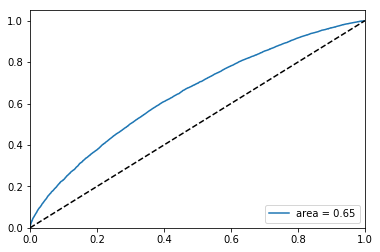

In [19]:
#Create ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pred_probas = lr.predict_proba(test_vecs)[:,1]

fpr,tpr,_ = roc_curve(y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

## Предобученный word2vec

In [34]:
from gensim.models.word2vec import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import accuracy_score

In [22]:
w2v_fpath = "./extra_data/tenth.norm-sz500-w7-cb0-it5-min5.w2v"
w2v = Word2Vec.load_word2vec_format(w2v_fpath, binary=True, unicode_errors='ignore')
w2v.init_sims(replace=True)
for word, score in w2v.most_similar(u"дерево"):
    print word, score

деревце 0.690682768822
дерево, — 0.675177156925
дерево… 0.671715199947
дерева 0.660127937794
дуб 0.651272594929
росшее 0.646113097668
деревцо 0.633637666702
раскидистое 0.619828283787
сосну 0.618146181107
тамариндовое 0.611433327198


In [ ]:
for word, score in w2v.most_similar(u"отстой"):
    print word, score

In [25]:
num_features = 500
train_vecs_500 = np.concatenate([buildWordVector(z, num_features, w2v) for z in x_train])
train_vecs_500 = scale(train_vecs)

In [26]:
test_vecs_500 = np.concatenate([buildWordVector(z, num_features, w2v) for z in x_test])
test_vecs_500 = scale(test_vecs)

In [36]:
test_vecs_500.shape

(45367, 512)

In [37]:
test_vecs_500[:5]

array([[-0.66371528,  1.05913341, -0.07053109, ...,  0.21252357,
         0.21448609, -0.37020442],
       [ 0.37055792,  0.44323189, -1.41644284, ..., -2.88811367,
         0.89723526, -0.39087373],
       [-0.13622262, -0.23606224,  0.18231464, ...,  0.54742896,
         0.15671542,  0.13755789],
       [ 0.12005125, -0.64971494,  1.08217057, ..., -0.4551701 ,
         0.40910788,  1.18134595],
       [-0.19381813, -0.51631479, -0.18452572, ...,  0.11181918,
         2.42369818,  1.68570594]])

In [31]:
model_logreg = LogisticRegression(penalty='l1', C=0.1)

In [32]:
model_logreg.fit(train_vecs_500, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
preds_logreg = model_logreg.predict(test_vecs_500)
print accuracy_score(preds_logreg, y_test)

0.611545837283


In [ ]:
import 